## Brief Introduction
This notebook shows how to use PCA method to downsize the dimensions of the dataset, and implement Anomaly Detection with two methods:
1. Use the probability based on the Multivariate Gaussian Distribution.
2. Use the Reconstruction Error Method

The anomaly in the datast is a figure with mustache.

Data Source: http://vision.ucsd.edu/~iskwak/ExtYaleDatabase/ExtYaleB.html

In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from PIL import Image
from scipy.io import loadmat  
from scipy import stats  
from scipy.stats import multivariate_normal
import re
import glob
from operator import itemgetter 
import random

from support_functions import *

## Read in Images and Remove Over-shadowed Ones

In [2]:
# Define the images to be read and the corresponding labels
label_1_folder = [9,21]
target_folders = range(1,22)
data_path = "Yale Face B/CroppedYale/"

# We also need to reduce the size of the image for the convenience of computation
reduce_height = 24
reduce_width = 21

# Read the images and reduce the size
images,labels = read_images(data_path,target_folders,label_1_folder,reduce_height,reduce_width)

# Number of labels as "Anomaly" and Total Number of Labels
sum(labels),len(labels)

(126, 1243)

(598, ' images are above our threshold and thus removed from the list')


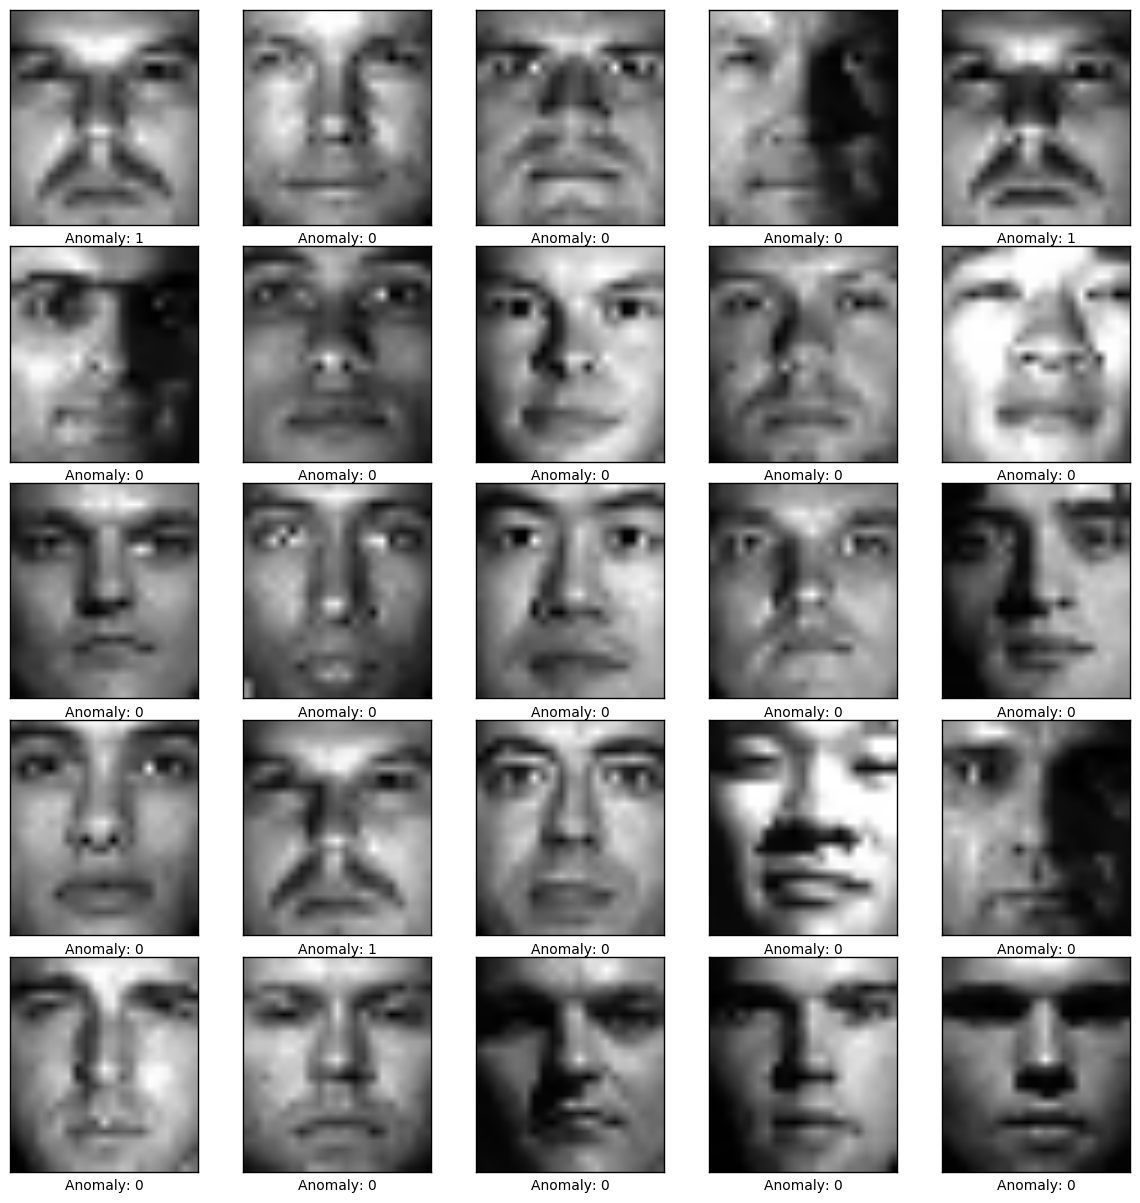

In [3]:
# To evaluate the threshold of the dark pixels
# dark_pixel_curve(images)

imgs = images[:] # Create a copy
# Eliminate the images and labels whose number of dark pixels are above the threshold
# The threshold is determined based on the dark_pixel_curve() function above
imgs,labels,remove_count = remove_dark_img(imgs,labels,180) 

plot_images(imgs,labels)

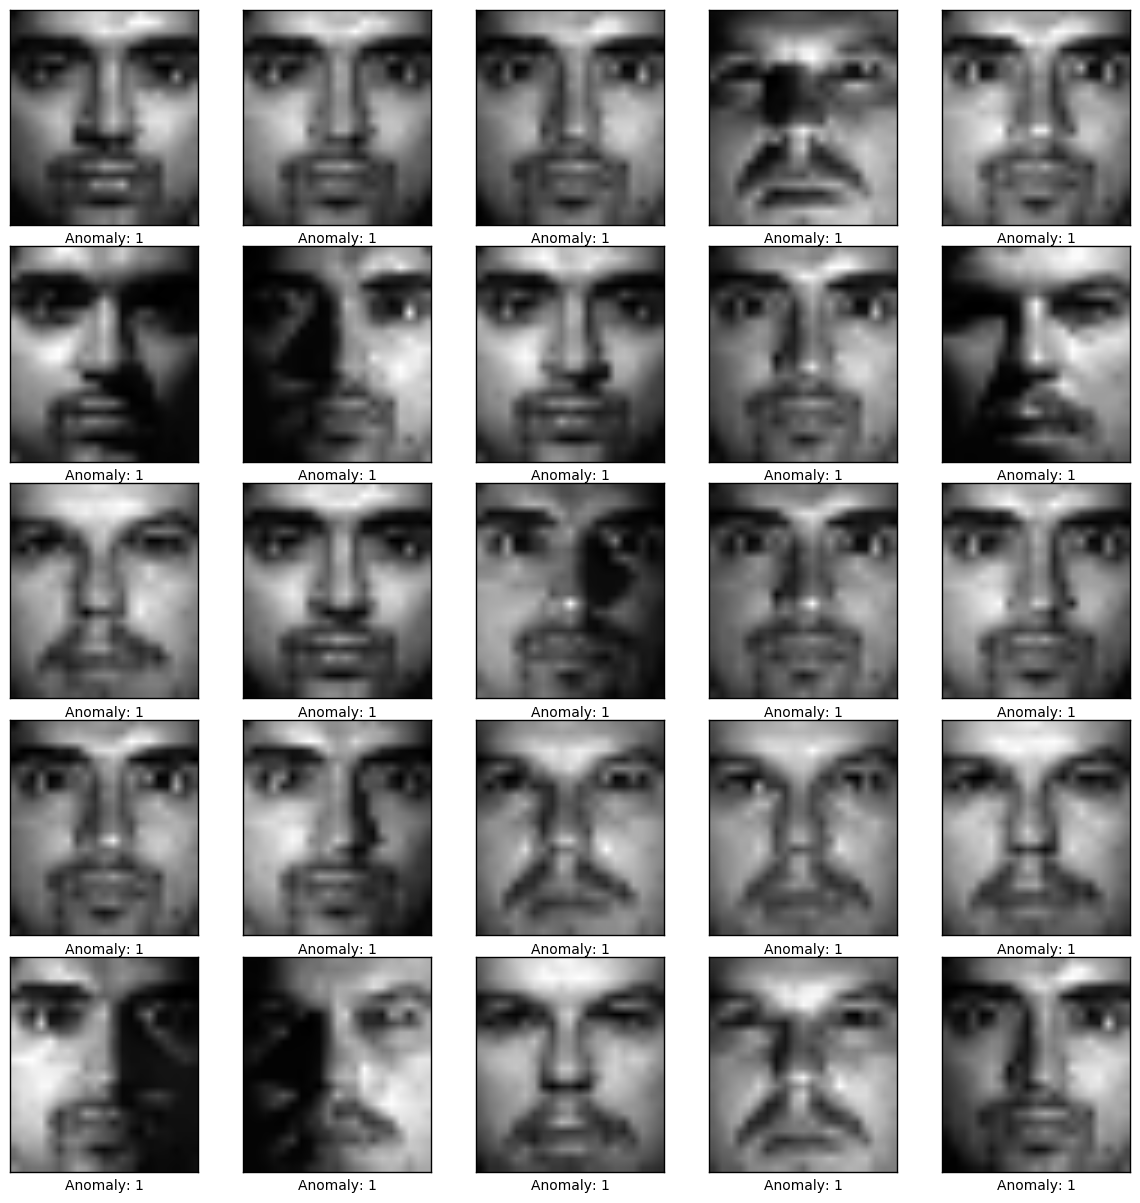

In [4]:
# Randomly select and show anomalous images
show_anomaly_images(imgs,labels)

## Apply PCA for Dimension Reduction

In [5]:
# Define the number of Principal Components we want to keep from the image
n_components = 20

# Find the dimension of one image
height, width = imgs[0].shape
num_imgs = len(imgs)
height, width,num_imgs

(24, 21, 645)

### Convert the Images List to a 2-Dimensional Matrix
Convert each image from 2D to 1D array, and each column of the new matrix will be one image.

In [6]:
# Initialize the matrix to store the entire image list
imgs_matrix = np.zeros((height*width,num_imgs)) 

# Iterate through each image, convert it into an array, and add to the imgs_matrix as a column
for i in range(0,len(imgs)):
    imgs_matrix[:,i] = imgs[i].reshape(height*width)
imgs_matrix.shape

(504, 645)

### Take a Mean-Shift
We applied the Mean-Shift on each component before computing the Covariance Matrix. It is important to save the vector of the components' mean: we will use it when we reconstruct the data after we applied PCA

In [7]:
img_matrix_shifted, component_mean = mean_shift(imgs_matrix)

### Compute the Covariance Matrix of the Image Matrix
The Covariance Matrix should be a symmetric square matrix with shape $n*n$, where $n$ is the row number of the Image Matrix, or **the number of the components**.

In [8]:
cov_matrix = np.cov(img_matrix_shifted)
cov_matrix.shape

(504, 504)

### Compute the eigenvectors and the corresponding eigenvalues based on the Covariance Matrix

In [9]:
# Compute the eigen value and eigen vectors
eigen_value, eigen_vector = np.linalg.eig(cov_matrix)

# Sort the eigenvectors by decreasing eigenvalues
# First make a list of (eigenvalue, eigenvector) tuples 
eig_pairs = [(np.abs(eigen_value[i]), eigen_vector[:,i]) for i in range(len(eigen_value))] 
# Sort the (eigenvalue, eigenvector) tuples from high to low 
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Convert the sorted eigen vector list to matrix form
eigen_vector_sorted = np.zeros((height*width,n_components))
for i in range(0,n_components):
    eigen_vector_sorted[:,i] = eig_pairs[i][1]

### Compute the PCA Matrix and Visualize the Eigenfaces

In [10]:
# Cut the sorted eigenvectors by columns to get the transformational matrix for PCA
pca_matrix = eigen_vector_sorted[:,:n_components]
pca_matrix.shape

(504, 20)

In [11]:
# Visualize the eigenfaces with the pca matrix
plot_eigenfaces(pca_matrix,height, width)

### Reconstruct the Face Images after PCA
First we applies PCA on the image data matrix to downsize its dimensions. Then we reconstruct the image matrix through the PCA matrix and add the mean of each component back. Finally we plot several examples to compare the original face images with the reconstructed face images. 

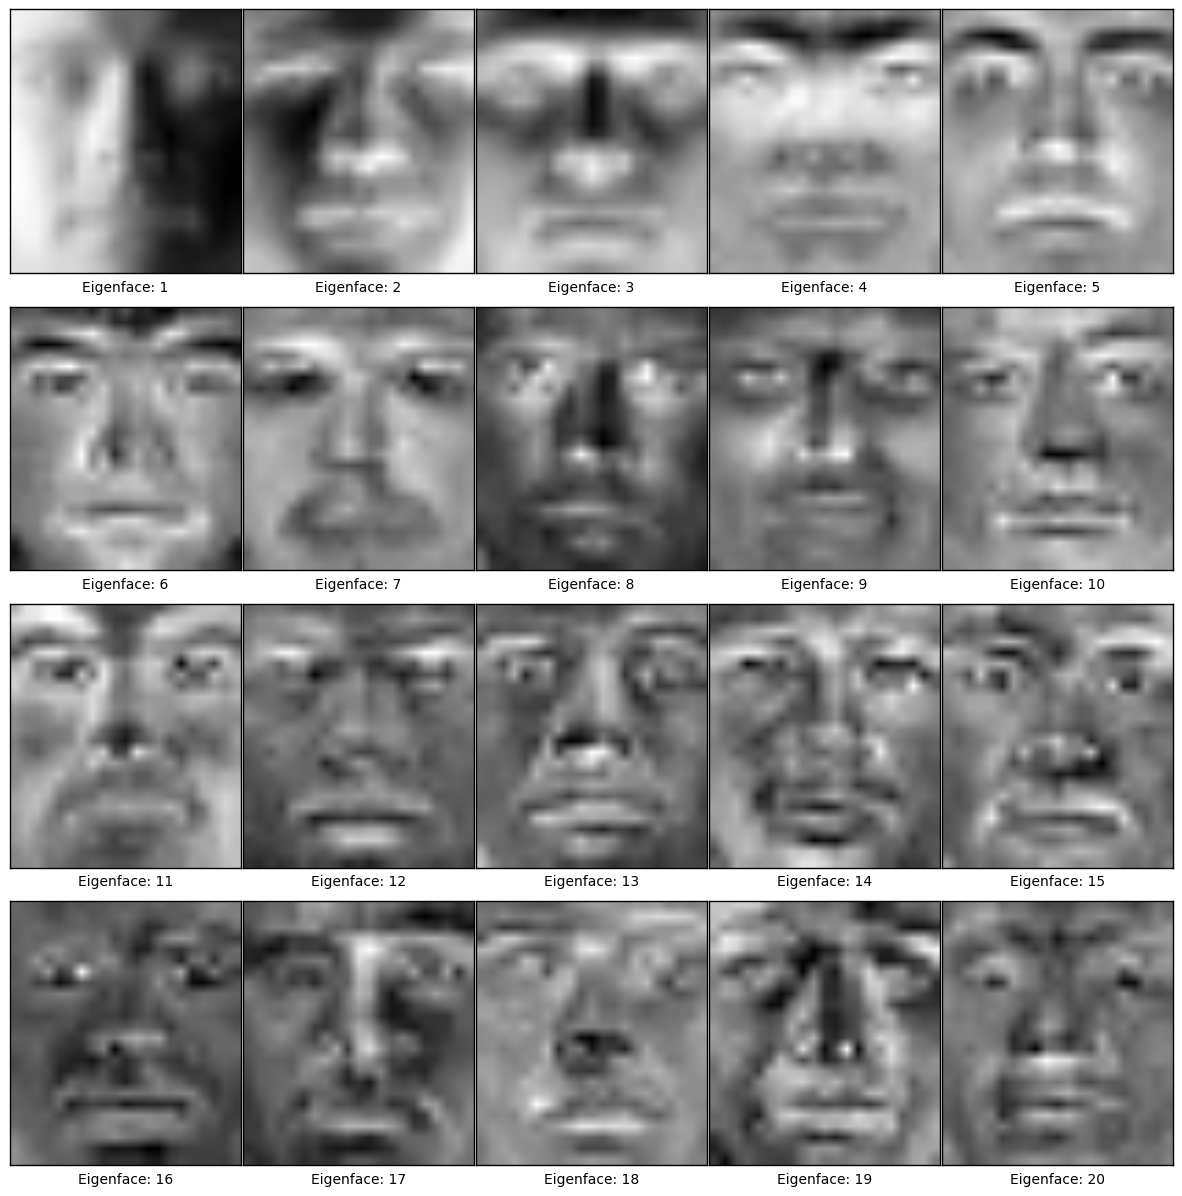

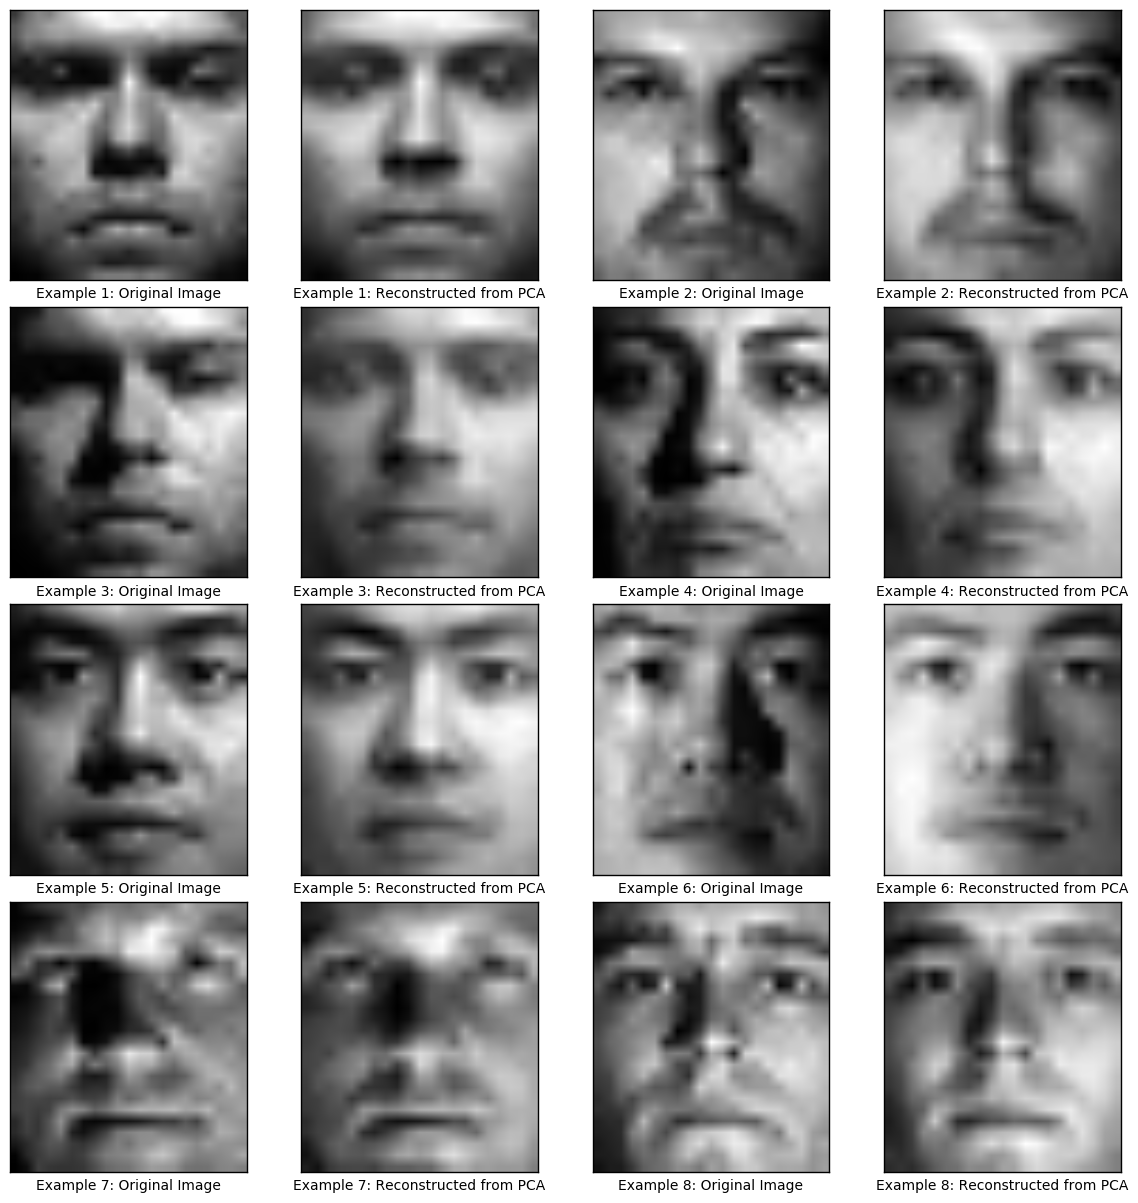

In [12]:
# Compute the transformed image
# Shape of pca_matrix: n * k
# Shape of imgs_matrix: n * m
# Shape of the transformed face image matrix: k * m
img_pca_tranf = pca_matrix.T.dot(img_matrix_shifted)

# Reconstruct through PCA Matrix and Mean Vector
# Shape of the reconstructed face image matrix: n * m
# component_mean is a vector and we need to convert it to a one-column matrix for the addition
img_matrix_reconst = pca_matrix.dot(img_pca_tranf) + component_mean.reshape(height*width,1)

# Plot the original images and their reconstructed version for comparison
plot_compare_after_reconst(img_matrix_reconst,imgs_matrix,height,width)

## Anomaly Detection
We will use two methods of the Anomaly Detection. 
1. We will use the probability based on the Multivariate Gaussian Distribution.
2. We will use the Reconstruction Error Method

### Split the Data into the Training and Validation Set
With the function, we get the indice of images to be assigned to the training and the validation set

In [13]:
# Vectorize the labels list
labels_vector = np.hstack(labels) # Easier to get multiple items from a vector than from a list

# Split the images and labels
ratio = 0.8 # 80% of the images will be splitted to the training set
train_ind, test_ind = split_training(labels_vector,ratio)

imgs_train = img_pca_tranf[:,train_ind]
imgs_test = img_pca_tranf[:,test_ind]
labels_train = labels_vector[train_ind]
labels_test = labels_vector[test_ind]

imgs_train.shape, imgs_test.shape, labels_train.shape,labels_test.shape

((20, 515), (20, 129), (515,), (129,))

### Method 1: Multivariate Gaussian Distribution

In [14]:
# We need to separete the data to get different Gaussian Distribution Model
imgs_train_anomaly = imgs_train[:,labels_train == 1]
imgs_train_normal = imgs_train[:,labels_train == 0]

# Get Gaussian Distribution Model from the Anomaly Data and Normal Data Separately
# Note: fit_multivariate_gaussian() is my own coded function
dist_anomaly = fit_multivariate_gaussian(imgs_train_anomaly.T)
dist_normal = fit_multivariate_gaussian(imgs_train_normal.T)

# Get Probability of being Anomaly vs. being Normal
p_train_anomaly = dist_anomaly.pdf(imgs_train.T) # Probability of Being Abnormal
p_train_normal = dist_normal.pdf(imgs_train.T)   # Probability of Being Normal

# Train the Anomaly Detector
threshold_anomaly = select_threshold(p_train_anomaly, labels_train, p_anomaly_switch = 1)
threshold_normal  = select_threshold(p_train_normal, labels_train, p_anomaly_switch = 0)

In [15]:
# Case 1: Predict with only the threshold at the probability of being anomaly
preds1 = p_train_anomaly > threshold_anomaly
tpr,tnr,fpr,fnr,f1 = eval_prediction(preds1,labels_train,rate = True)
tpr,tnr,fpr,fnr,f1

(0.625, 1.0, 0.0, 0.375, 0.76923076923076927)

In [16]:
# Case 2: Predict with only the threshold at the probability of being normal
preds2 = p_train_normal < threshold_normal
tpr,tnr,fpr,fnr,f1 = eval_prediction(preds2,labels_train,rate = True)
tpr,tnr,fpr,fnr,f1

(1.0, 0.46466809421841543, 0.53533190578158463, 0.0, 0.2774566473988439)

In [17]:
# Case 3: Predict as Anomaly if one of the detector claims as Anomaly
np.logical_or(p_train_anomaly > threshold_anomaly, p_train_normal < 0)
# preds3 = (p_train_anomaly < threshold_anomaly)*(p_train_normal > threshold_normal)
preds3 = np.logical_or(p_train_anomaly > threshold_anomaly, p_train_normal < threshold_normal)
tpr,tnr,fpr,fnr,f1 = eval_prediction(preds3,labels_train,rate = True)
tpr,tnr,fpr,fnr,f1

(1.0, 0.46466809421841543, 0.53533190578158463, 0.0, 0.2774566473988439)

In [18]:
# Case 4: Predict as Anomaly if both of the detectors claim as Anomaly
preds4 = np.logical_and(p_train_anomaly > threshold_anomaly, p_train_normal < threshold_normal)
tpr,tnr,fpr,fnr,f1 = eval_prediction(preds4,labels_train,rate = True)
tpr,tnr,fpr,fnr,f1

(0.625, 1.0, 0.0, 0.375, 0.76923076923076927)

From the examination above, we can find the detector of being anomaly alone perform much better than the detector of being abnormal.

#### Apply on the Test Set

In [19]:
p_test_anomaly = dist_anomaly.pdf(imgs_test.T)   # Probability of Being Normal
preds_test = p_test_anomaly > threshold_anomaly
tpr,tnr,fpr,fnr,f1 = eval_prediction(preds_test,labels_test,rate = True)
tpr,tnr,fpr,fnr,f1

(0.46153846153846156, 1.0, 0.0, 0.53846153846153844, 0.63157894736842102)

### Method 2: PCA Reconstruction Error
The method will measure the Euclidean distance between each data point on the image and its new point after reconstruction from the PCA, whcih was generated sololy with the Normal Data. The basis of this method is that the Anomalies will give large values of distance. I will use the training data to find the optimal threshold to identify the Anomalies. 

#### Generate a new PCA sololy with the Normal Data
Since we need to re-run a new PCA, we need to go back to the place where we took a Mean Shift on the Image Matrix and start over again

In [20]:
# Isolate the Normal Data from the Training Set
# Note: we use the same index but on the img_matrix_shifted
img_matrix_shifted_train = img_matrix_shifted[:,train_ind]
img_matrix_shifted_train_normal = img_matrix_shifted_train[:,labels_train == 0]

pca_matrix_normal = compute_pca_matrix(img_matrix_shifted_train_normal, n_components,height, width)

# Visualize the new eigenfaces
#plot_eigenfaces(pca_matrix_normal,height, width)

support_functions.py:315: ComplexWarning: Casting complex values to real discards the imaginary part
  eigen_vector_sorted[:,i] = eig_pairs[i][1]


#### Reconstruct the Data with the new PCA Matrix
Use the PCA on both the Normal and Anomalous Data

In [21]:
img_pca_tranf_new = pca_matrix_normal.T.dot(img_matrix_shifted) # Apply on all the data

# Reconstruct through PCA Matrix and Mean Vector
img_matrix_reconst_new = pca_matrix_normal.dot(img_pca_tranf_new) + component_mean.reshape(height*width,1)

#### Find the Optimal Threshold based on the training dataset

In [22]:
# Find the euclidean distance between the reconstructed dataset and the original ()
dist = find_euclidean_distance(img_matrix_reconst_new,imgs_matrix)
np.min(dist),np.mean(dist),np.max(dist)

(155.36272633932802, 355.15093653486554, 815.33604895092049)

In [23]:
dist_train= dist[train_ind]
threshold2, tpr,tnr,fpr,fnr,f1 = select_threshold_distance(dist_train, labels_train)
tpr,tnr,fpr,fnr,f1

(0.45833333333333331,
 0.99357601713062094,
 0.0064239828693790149,
 0.54166666666666663,
 0.60273972602739723)

#### Apply on the Test Set

In [24]:
dist_test= dist[test_ind]
preds_test2 = dist_test > threshold2
tpr,tnr,fpr,fnr,f1 = eval_prediction(preds_test2,labels_test,rate = True)
tpr,tnr,fpr,fnr,f1

(0.30769230769230771,
 0.9568965517241379,
 0.043103448275862072,
 0.69230769230769229,
 0.27350427350427353)